In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import Kernel

from dataset.dodd import load_dodd

from onlineKernels.klmsRFF import *
from onlineKernels.knlmsRFF import *
from onlineKernels.krlsRFF import *

from syncFL import fl_sync
from asyncFL import fl_async
from cent_learn import cent_learn
# Multiprocessing
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.31it/s]


(0.0, 3000.0)

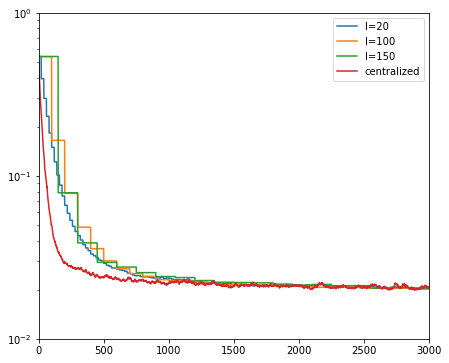

In [4]:
# Parameters
num_data = 3000
kernel = Kernel(3.73)

step_size = 0.8
reg_coeff = 0.1
threshold = 0.5
# Federated learning: Synchronous updating rule
plt.figure(figsize=(7, 6))

K = 10 # K edge clients
c =  np.ones(K).reshape(K,1)/K # edge weighting
D = 50 # Dictionary size
L = [20, 100, 150]
iteration = 10000
num_experiments = 10

step_size = 0.8
KLMS_RFF = klms_rff(step_size,D)
# KLMS_RFF = KLMS(u,d,kernel,step_size,threshold,alpha_0=np.array(0).reshape(1,1))
KLMS_RFF_cent = klms_rff(0.2,D)
KNLMS_RFF = knlms_rff(step_size,reg_coeff,D)
KRLS_RFF = krls_rff(D)
for l in L:
    amse = np.zeros(iteration)
    amse_cent = np.zeros(iteration)
    for epoch in tqdm(range(num_experiments)):

        # Process data and kernel
        u,d,d_true = load_dodd(num_data)
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(2,D))
        b = np.random.uniform(0,2*np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

        FLsync = fl_sync(K,h,l)
        
        # Federated learning
        mse_cent = cent_learn(iteration,K,KLMS_RFF_cent,h,u,d)
        amse_cent += mse_cent/num_experiments
        mse = FLsync.train(iteration,KLMS_RFF,u,d)
        amse += mse/num_experiments

    plt.semilogy(range(len(amse)),amse,label="l=" + str(l))
plt.semilogy(range(len(amse_cent)),amse_cent,label="centralized")
plt.legend()
plt.ylim([1e-2,1e0])
plt.xlim([0,3000])

100%|███████████████████████████████████████████| 10/10 [00:39<00:00,  3.94s/it]


Text(0, 0.5, 'MSE')

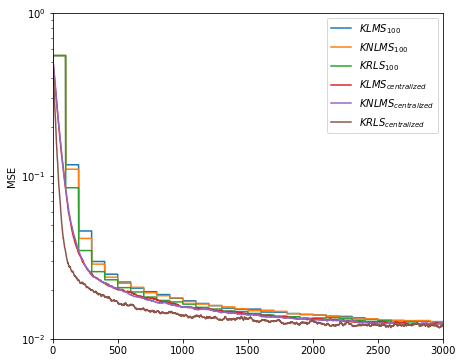

In [112]:
# Synchronous Federated learning using different kernels

num_data = 3000
kernel = Kernel(3.73)

step_size = 0.8
reg_coeff = 1e-6
plt.figure(figsize=(7, 6))

K = 10 # K edge clients
c = np.ones(K).reshape(K,1)/K # edge weighting
D = 100 # Dictionary size
L = [100]
iteration = 10000
num_experiments = 10

KLMS_RFF = klms_rff(step_size,D)
KNLMS_RFF = knlms_rff(step_size,reg_coeff,D)
KRLS_RFF = krls_rff(D,beta=0.01,l=1.0)
KLMS_RFF_cent = klms_rff(0.1,D)
KNLMS_RFF_cent = knlms_rff(0.1,1e-8,D)
KRLS_RFF_cent = krls_rff(D,beta=4,l=1.0)
for l in L:
    amse_KLMS = np.zeros(iteration)
    amse_KNLMS = np.zeros(iteration)  
    amse_KRLS = np.zeros(iteration)  
    amse_KLMS_cent = np.zeros(iteration)
    amse_KNLMS_cent = np.zeros(iteration)  
    amse_KRLS_cent = np.zeros(iteration)    

    for epoch in tqdm(range(num_experiments)):

        # Process data and kernel
        u,d,d_true = load_dodd(num_data)
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(2,D))
        b = np.random.uniform(0,2*np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

        FLsync = fl_sync(K,h,l)
        
        mse_KLMS_cent = cent_learn(iteration,K,KLMS_RFF_cent,h,u,d)
        amse_KLMS_cent += mse_KLMS_cent/num_experiments
        mse_KNLMS_cent = cent_learn(iteration,K,KNLMS_RFF_cent,h,u,d)
        amse_KNLMS_cent += mse_KNLMS_cent/num_experiments
        mse_KRLS_cent = cent_learn(iteration,K,KRLS_RFF_cent,h,u,d)
        amse_KRLS_cent += mse_KRLS_cent/num_experiments
        
        mse_KLMS = FLsync.train(iteration,KLMS_RFF,u,d)
        amse_KLMS += mse_KLMS/num_experiments
        mse_KNLMS = FLsync.train(iteration,KNLMS_RFF,u,d)
        amse_KNLMS += mse_KNLMS/num_experiments
        mse_KRLS = FLsync.train(iteration,KRLS_RFF,u,d)
        amse_KRLS += mse_KRLS/num_experiments  
        
plt.semilogy(range(len(amse_KLMS)),amse_KLMS,label="$KLMS_{" + str(l)+"}$")
plt.semilogy(range(len(amse_KNLMS)),amse_KNLMS,label="$KNLMS_{" + str(l)+"}$")
plt.semilogy(range(len(amse_KRLS)),amse_KRLS,label="$KRLS_{" + str(l)+"}$")
plt.semilogy(range(len(amse_KLMS_cent)),amse_KLMS_cent,label="$KLMS_{centralized}$")
plt.semilogy(range(len(amse_KNLMS_cent)),amse_KNLMS_cent,label="$KNLMS_{centralized}$")
plt.semilogy(range(len(amse_KRLS_cent)),amse_KRLS_cent,label="$KRLS_{centralized}$")
plt.legend()
plt.ylim([1e-2,1e0])
plt.xlim([0,3000])
plt.ylabel("MSE")
plt.xlabel("iteration")

Text(0, 0.5, 'MSE')

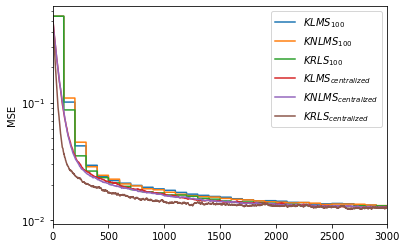

In [110]:
plt.semilogy(range(len(amse_KLMS)),amse_KLMS,label="$KLMS_{" + str(l)+"}$")
plt.semilogy(range(len(amse_KNLMS)),amse_KNLMS,label="$KNLMS_{" + str(l)+"}$")
plt.semilogy(range(len(amse_KRLS)),amse_KRLS,label="$KRLS_{" + str(l)+"}$")
plt.semilogy(range(len(amse_KLMS_cent)),amse_KLMS_cent,label="$KLMS_{centralized}$")
plt.semilogy(range(len(amse_KNLMS_cent)),amse_KNLMS_cent,label="$KNLMS_{centralized}$")
plt.semilogy(range(len(amse_KRLS_cent)),amse_KRLS_cent,label="$KRLS_{centralized}$")
plt.legend()
# plt.ylim([1e-2,2e-2])
plt.xlim([0,3000])
plt.ylabel("MSE")

100%|███████████████████████████████████████████| 25/25 [00:29<00:00,  1.19s/it]


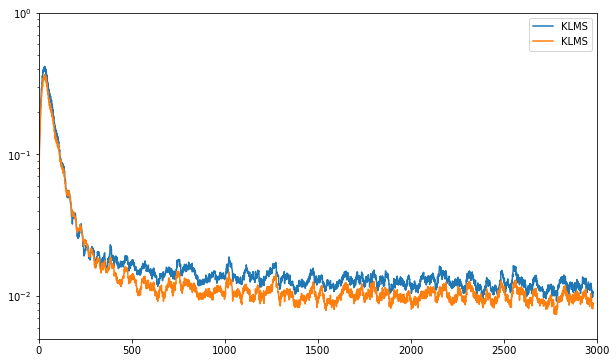

In [5]:
num_experiments = 25
D = 100
# Experiment
mse_KNLMS = np.zeros(num_data)
mse_KNLMS_RFF = np.zeros(num_data)

for i in tqdm(range(num_experiments)):
#     print('experiment',i+1)
    u,d,d_true = generate_data(num_data)
    
    sigma = 1/np.sqrt(2*kernel.sigma)
    W = (1/sigma) * np.random.normal(size=(2,D))

    b = np.random.uniform(0,np.pi,(D,1))
    h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)
    KLMS = KLMS_RFF(d,h,step_size,D,alpha_0 = np.zeros((D,1)))
    
    err_KNLMS,_,_ = KNLMS(u,d,kernel,step_size,threshold,0.5)
    mse_KNLMS += ((np.array(d_true) - np.array(d) + err_KNLMS)**2)/num_experiments
    err_KNLMS_RFF,_ = KLMS.train()
    mse_KNLMS_RFF += ((np.array(d_true) - np.array(d) + err_KNLMS_RFF)**2)/num_experiments
    
mse_KNLMS_smooth = np.convolve(mse_KNLMS,np.ones(20)/20,'valid')
mse_KNLMS_RFF_smooth = np.convolve(mse_KNLMS_RFF,np.ones(20)/20,'valid')

plt.figure(figsize=(10, 6))
plt.semilogy(range(len(mse_KNLMS_smooth)),mse_KNLMS_smooth, label='KLMS')
plt.semilogy(range(len(mse_KNLMS_RFF_smooth)),mse_KNLMS_RFF_smooth, label='KLMS')
plt.ylim([0.005,1e0])
plt.xlim([0,3000])
plt.legend()
plt.show()

In [13]:
import numpy as np
D = 100
step_size = 0.2
reg_coeff = 0.03
threshold = 0.5
num_data = 3000
kernel = Kernel(3.73)
class krls_rff:
    
    def __init__(self,D,beta=1.0,l=1.0):
        self.D = D
        self.beta = beta
        self.l = l
        self.P = np.eye(D)/l
     
    def train(self,h,d,alpha_0,P=None):
        D = self.D
        beta = self.beta
        l = self.l
        lambd = 0
        alpha = alpha_0
        err = []
        if (P.any()):
            P = self.P
        k = h[0,0]
#         print(h.shape)
        K_inv = np.matrix(1/(lambd + k))
        alpha = alpha_0
        
        for n in range(1,len(d)):
            k = h[n,n]
#             print(k)
            h_n = h.T[n].reshape((D,1))
            a = P @ h
#             print(lambd + k - h.T @ a)
            delta = (lambd + k - h.T @ a).item()
            P_top = np.c_[delta*P + a @ a.T,-a]
            P_bot = np.c_[-a.T, 1]
            P = np.r_[P_top,P_bot]
            P /= delta
            
            err.append((d[n] - h_n.T @ alpha).item()) 
            alpha = np.array(alpha - ((a * err[-1])/delta)).reshape(m,1)
            alpha = np.r_[alpha,[[err[-1]/delta]]]
                        
        return err,alpha,P
# Experiment
mse = np.zeros(num_data)
num_experiments = 25
KRLS_RFF = krls_rff(D)
for ii in tqdm(range(num_experiments)):
    u,d,d_true = load_dodd(num_data)
    sigma = 1/np.sqrt(2*kernel.sigma)
    W = (1/sigma) * np.random.normal(size=(2,D))
    b = np.random.uniform(0,2*np.pi,D).reshape(D,1)
    h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)


    err,_,_ = KRLS_RFF.train(h,d,np.zeros((D,1)),KRLS_RFF.P)
    mse = mse + (np.square((d_true - d) + err))/num_experiments

mse_smooth = np.convolve(mse,np.ones(20)/20,'valid')
plt.figure(figsize=(10, 6))
plt.semilogy(range(len(mse_smooth)),mse_smooth)
plt.ylim([0.005,1e0])
plt.xlim([0,3000])
plt.show()

  0%|                                                    | 0/25 [00:00<?, ?it/s]


ValueError: can only convert an array of size 1 to a Python scalar

-0.12411577643639983

In [48]:
def KRLS_RFF2(u,d,kernel,l,beta,D):

    err = np.array([])

    W = np.random.normal(loc=0, scale=2.25, size=(2,D))
    b = np.random.uniform(0,2*np.pi,D).reshape(D,1)
    
    # Initalization
    P = np.eye(D)/l
    alpha = np.zeros((D,1))
    for n in range(1, len(d)):
        u_n = u[n].reshape(1,2)
        d_n = d[n]
        k = kernel(u_n,u_n)
        h = np.sqrt(2/D) * np.cos(W.T @ u_n + b)
        a = K_inv @ h
        delta = (k - h.T @ a).item()
        err = np.append(err,d_n - h.T @ alpha)
        if delta > threshold:
            dictionary = np.r_[dictionary, u_n]

            K_inv_num = np.c_[delta*K_inv + a @ a.T,-a]
            K_inv_den = np.c_[-a.T, 1]
            K_inv = np.r_[K_inv_num,K_inv_den]
            K_inv = K_inv/delta

            P_num = np.c_[P,np.zeros((m,1))]
            P_den = np.c_[np.zeros((m,1)).T, 1]
            P = np.r_[P_num,P_den]

            alpha = np.array(alpha - ((a * err[-1])/delta)).reshape(m,1)
            alpha = np.r_[alpha,[[err[-1]/delta]]]
            m = m + 1


        q_t = (P @ a)/(1 + a.T @ P @ a)
        P = P - ((P @ a @ a.T @ P)/(1 + a.T @ P @ a))

        alpha = alpha + K_inv @ q_t * err[-1]

#     print('number of SVs',len(dictionary))
    return err

# Experiment
mse = np.zeros(num_data)

for i in tqdm(range(num_experiments)):
#     print('experiment',i+1)
    u,d,d_true = generate_data(num_data)
    startTime = time.time()
    err = KRLS_RFF2(u,d,kernel,0.1,1,20)
#     mse = mse + (((d_true - d) + err)**2)/num_experiments

# mse_smooth = np.convolve(mse,np.ones(20)/20,'valid')

array([0.0033299 , 0.03037374, 0.00868982, ...,        nan,        nan,
              nan])

In [ ]:
d_true =[0.1 , 0.1]
d = [d_true[0], d_true[1]]

# Grab new data
new_d_true = lambda x: x.append((0.8 - 0.5 * np.exp(-(x[-1]**2)))*x[-1] - (0.3 + 0.9*np.exp(-(x[-1]**2)))*x[-2] + 0.1*np.sin(np.pi*x[-1]))
for i in range(2,num_data+2):
    print(new_d_true(d_true))
    d.append(d_true[-1] + np.random.normal(0.0,0.1))

True